In [171]:
from pyforest import *
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump, load

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor

from dateutil.parser import parse

import warnings
warnings.filterwarnings('ignore')

In [106]:
data = pd.read_excel('../../data/power-watt/Hourly Actual Reading Nation.xlsx')

In [107]:
data.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,NaN,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,...,NaN,NaN,NaN,2020,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,HOURS,Thermal,Hydro,Import,Total,Valco Demand,Export,NaN,HOURS,...,Valco Demand,Export,NaN,HOURS,Thermal,Hydro,Import,Total,Valco Demand,Export
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2017-01-01 00:00:00,676.5,722,-125,1523.5,70.1,0,NaN,2018-01-01 00:00:00,...,88.1,0,NaN,2020-01-01 00:00:00,1435.2,669.2,0,2104.4,51.5,0
4,NaN,2017-01-01 01:00:00,674.3,788,-106,1568.3,70.5,0,NaN,2018-01-01 01:00:00,...,85.3,9,NaN,2020-01-01 01:00:00,1452.3,643.7,0,2096,57.2,0


In [108]:
# data[['Unnamed: 32']]
myData = data.copy()

In [109]:
myData = myData[['Unnamed: 1', 'Unnamed: 5', 'Unnamed: 9', 'Unnamed: 13', 'Unnamed: 17', 'Unnamed: 21', 'Unnamed: 25', 'Unnamed: 29']]

In [110]:
myData.head()

,Unnamed: 1,Unnamed: 5,Unnamed: 9,Unnamed: 13,Unnamed: 17,Unnamed: 21,Unnamed: 25,Unnamed: 29
0,2017,NaN,2018,NaN,2019,NaN,2020,NaN
1,HOURS,Total,HOURS,Total,HOURS,Total,HOURS,Total
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 00:00:00,1523.5,2018-01-01 00:00:00,1571.8,2019-01-01 00:00:00,1832.4,2020-01-01 00:00:00,2104.4
4,2017-01-01 01:00:00,1568.3,2018-01-01 01:00:00,1581.5,2019-01-01 01:00:00,1856.1,2020-01-01 01:00:00,2096


In [111]:
myData.columns = ['2017 Date', '2017 Power', '2018 Date', '2018 Power', '2019 Date', '2019 Power', '2020 Date', '2020 Power']

In [112]:
myData.head()

,2017 Date,2017 Power,2018 Date,2018 Power,2019 Date,2019 Power,2020 Date,2020 Power
0,2017,NaN,2018,NaN,2019,NaN,2020,NaN
1,HOURS,Total,HOURS,Total,HOURS,Total,HOURS,Total
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 00:00:00,1523.5,2018-01-01 00:00:00,1571.8,2019-01-01 00:00:00,1832.4,2020-01-01 00:00:00,2104.4
4,2017-01-01 01:00:00,1568.3,2018-01-01 01:00:00,1581.5,2019-01-01 01:00:00,1856.1,2020-01-01 01:00:00,2096


In [113]:
# myData.drop(columns = myData.columns, index=[0, 1, 2], inplace=True)
myData = myData.drop([0,1,2]).reset_index(drop=True)

In [114]:
myData.head()

,2017 Date,2017 Power,2018 Date,2018 Power,2019 Date,2019 Power,2020 Date,2020 Power
0,2017-01-01 00:00:00,1523.5,2018-01-01 00:00:00,1571.8,2019-01-01 00:00:00,1832.4,2020-01-01 00:00:00,2104.4
1,2017-01-01 01:00:00,1568.3,2018-01-01 01:00:00,1581.5,2019-01-01 01:00:00,1856.1,2020-01-01 01:00:00,2096
2,2017-01-01 01:59:59.990000,1541.8,2018-01-01 02:00:00,1549.5,2019-01-01 02:00:00,1859.1,2020-01-01 01:59:59.990000,2073.8
3,2017-01-01 02:59:59.985000,1508,2018-01-01 03:00:00,1521.8,2019-01-01 03:00:00,1819.8,2020-01-01 02:59:59.985000,2051.1
4,2017-01-01 03:59:59.980000,1488.7,2018-01-01 04:00:00,1508.9,2019-01-01 04:00:00,1832.5,2020-01-01 03:59:59.980000,1947.1


In [115]:
myData.shape

(8784, 8)

In [116]:
data_2017 = myData[['2017 Date','2017 Power']]
data_2018 = myData[['2018 Date', '2018 Power']]
data_2019 = myData[['2019 Date', '2019 Power']]
data_2020 = myData[['2020 Date', '2020 Power']]

In [117]:
data_2018.columns = ['2017 Date','2017 Power']
data_2019.columns = ['2017 Date','2017 Power']
data_2020.columns = ['2017 Date','2017 Power']

In [118]:
data_2017.dropna(axis=0, inplace=True)
data_2017.isnull().sum()

2017 Date     0
2017 Power    0
dtype: int64

In [119]:
data_2017.shape

(8760, 2)

In [120]:
data_2018.isnull().sum()
data_2018.dropna(axis=0,inplace=True)
data_2018.isnull().sum()

2017 Date     0
2017 Power    0
dtype: int64

In [121]:
data_2018.shape

(8760, 2)

In [122]:
data_2019.dropna(axis=0, inplace=True)
data_2019.isnull().sum()
data_2019.shape

(8752, 2)

In [199]:
fullData = data_2017
fullData.isnull().sum()

2017 Date     0
2017 Power    0
dtype: int64

In [200]:
fullData = pd.concat([fullData, data_2018], axis = 0)

In [201]:
fullData.shape

(17520, 2)

In [202]:
fullData.isnull().sum()

2017 Date     0
2017 Power    0
dtype: int64

In [203]:
# fullData1 = fullData1[['2017 Date', '2017 Power']]

In [204]:
# fullData1.shape

In [205]:
fullData = pd.concat([fullData, data_2019],axis=0)

In [206]:
fullData.shape

(26272, 2)

In [207]:
fullData = pd.concat([fullData, data_2020], axis=0)

In [208]:
fullData.shape

(35056, 2)

In [209]:
fullData.head()

,2017 Date,2017 Power
0,2017-01-01 00:00:00,1523.5
1,2017-01-01 01:00:00,1568.3
2,2017-01-01 01:59:59.990000,1541.8
3,2017-01-01 02:59:59.985000,1508
4,2017-01-01 03:59:59.980000,1488.7


In [210]:
fullData.shape

(35056, 2)

In [211]:
# fullData.isnull().sum()

In [212]:
fullData.tail()

,2017 Date,2017 Power
8779,2020-12-31 19:00:43.390000,0
8780,2020-12-31 20:00:43.395000,0
8781,2020-12-31 21:00:43.400000,0
8782,2020-12-31 22:00:43.405000,0
8783,2020-12-31 23:00:43.410000,0


In [213]:
fullData.reset_index(drop=True)

,2017 Date,2017 Power
0,2017-01-01 00:00:00,1523.5
1,2017-01-01 01:00:00,1568.3
2,2017-01-01 01:59:59.990000,1541.8
3,2017-01-01 02:59:59.985000,1508
4,2017-01-01 03:59:59.980000,1488.7
...,...,...
35051,2020-12-31 19:00:43.390000,0
35052,2020-12-31 20:00:43.395000,0
35053,2020-12-31 21:00:43.400000,0
35054,2020-12-31 22:00:43.405000,0


In [214]:
fullData.columns = ['Date', 'Power']

In [215]:
fullData.dtypes

Date     object
Power    object
dtype: object

In [216]:
fullData.Date.isnull().sum()

0

In [217]:
fullData.shape

(35056, 2)

In [218]:
fullData.sample(3)

,Date,Power
5031,2019-07-29 15:00:00,1988.3
7194,2020-10-26 18:00:35.465000,0
3902,2020-06-11 14:00:19.005000,0


In [219]:
fullData['Date'] = pd.to_datetime(fullData['Date'])

In [220]:
fullData.dtypes

Date     datetime64[ns]
Power            object
dtype: object

In [221]:
fullData.index = pd.to_datetime(fullData.index)

In [222]:
holidays_2017 = ['2017-01-02', '2017-03-06', '2017-05-01', '2017-05-25', '2017-07-03','2017-09-21','2017-12-26']
holidays_2018 = ['2018-01-01', '2018-03-06', '2018-05-01', '2018-05-25', '2018-07-02', '2018-09-21','2018-12-26']
holidays_2019 = ['2019-01-01', '2019-01-07', '2019-03-06', '2019-05-01', '2019-08-05', '2019-09-23','2019-12-06', '2019-12-26']
holidays_2020 = ['2020-01-01', '2020-03-06']

special_events_2017 = ['2017-04-14','2017-04-17', '2017-06-26','2017-09-01', '2017-12-25']
special_events_2018 = ['2018-04-30', '2018-04-02', '2018-06-15','2018-08-22', '2018-12-25']
special_events_2019 = ['2019-04-19', '2019-04-22', '2019-06-05', '2019-08-12', '2019-12-25']

In [223]:
holidays = holidays_2017 + holidays_2018 + holidays_2019 + holidays_2020
holidays = [parse(hol).date() for hol in holidays]

In [224]:
special_events = special_events_2017 + special_events_2018 + special_events_2019
special_events = [parse(event).date() for event in special_events]

In [225]:
fullData['ActualDate'] = fullData['Date'].dt.date

In [226]:
fullData['Holiday'] = fullData['ActualDate'].isin(holidays) * 1
fullData['SpecialEvent'] = fullData['ActualDate'].isin(special_events) * 1

In [227]:
# fullData[fullData['ActualDate'] == parse(holidays_2017[0]).date()]
fullData.head()

,Date,Power,ActualDate,Holiday,SpecialEvent
1970-01-01 00:00:00.000000000,2017-01-01 00:00:00.000,1523.5,2017-01-01,0,0
1970-01-01 00:00:00.000000001,2017-01-01 01:00:00.000,1568.3,2017-01-01,0,0
1970-01-01 00:00:00.000000002,2017-01-01 01:59:59.990,1541.8,2017-01-01,0,0
1970-01-01 00:00:00.000000003,2017-01-01 02:59:59.985,1508,2017-01-01,0,0
1970-01-01 00:00:00.000000004,2017-01-01 03:59:59.980,1488.7,2017-01-01,0,0


In [228]:
fullData['Year'] = fullData['Date'].dt.year

In [229]:
fullData['Month'] = fullData['Date'].dt.month

In [230]:
fullData['Day'] = fullData['Date'].dt.day

In [231]:
fullData['Hour']  = fullData['Date'].dt.hour

In [232]:
fullData['DayOfYear'] = fullData['Date'].dt.dayofyear

In [233]:
fullData["weekday"] = fullData['Date'].dt.weekday

In [234]:
fullData['is_weekend'] = fullData.weekday.isin([5,6])*1

In [255]:
finalData = fullData.drop(['Date', 'ActualDate'], axis=1)

In [256]:
finalData.sample(4)

,Power,Holiday,SpecialEvent,Year,Month,Day,Hour,DayOfYear,weekday,is_weekend
1970-01-01 00:00:00.000005336,0,0,0,2020,8,10,8,223,0,0
1970-01-01 00:00:00.000003229,1769.5,0,0,2018,5,15,13,135,1,0
1970-01-01 00:00:00.000007427,0,0,0,2020,11,5,11,310,3,0
1970-01-01 00:00:00.000000674,2109.4,0,0,2019,1,29,2,29,1,0


In [257]:
finalData[finalData['Power'] == 0]

,Power,Holiday,SpecialEvent,Year,Month,Day,Hour,DayOfYear,weekday,is_weekend
1970-01-01 00:00:00.000000192,0,0,0,2020,1,9,0,9,3,0
1970-01-01 00:00:00.000000193,0,0,0,2020,1,9,1,9,3,0
1970-01-01 00:00:00.000000194,0,0,0,2020,1,9,2,9,3,0
1970-01-01 00:00:00.000000195,0,0,0,2020,1,9,3,9,3,0
1970-01-01 00:00:00.000000196,0,0,0,2020,1,9,4,9,3,0
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000008779,0,0,0,2020,12,31,19,366,3,0
1970-01-01 00:00:00.000008780,0,0,0,2020,12,31,20,366,3,0
1970-01-01 00:00:00.000008781,0,0,0,2020,12,31,21,366,3,0
1970-01-01 00:00:00.000008782,0,0,0,2020,12,31,22,366,3,0


In [258]:
finalData.shape

(35056, 10)

In [259]:
# finalData.drop(finalData[finalData['Power'] == 0].index, inplace=True)

In [260]:
finalData = finalData[finalData['Power'] != 0]

In [261]:
finalData[finalData['Power'] == 0]

,Power,Holiday,SpecialEvent,Year,Month,Day,Hour,DayOfYear,weekday,is_weekend


In [262]:
finalData.shape

(26464, 10)

In [263]:
finalData.isnull().sum()

Power           0
Holiday         0
SpecialEvent    0
Year            0
Month           0
Day             0
Hour            0
DayOfYear       0
weekday         0
is_weekend      0
dtype: int64

In [264]:
finalData.head()

,Power,Holiday,SpecialEvent,Year,Month,Day,Hour,DayOfYear,weekday,is_weekend
1970-01-01 00:00:00.000000000,1523.5,0,0,2017,1,1,0,1,6,1
1970-01-01 00:00:00.000000001,1568.3,0,0,2017,1,1,1,1,6,1
1970-01-01 00:00:00.000000002,1541.8,0,0,2017,1,1,1,1,6,1
1970-01-01 00:00:00.000000003,1508,0,0,2017,1,1,2,1,6,1
1970-01-01 00:00:00.000000004,1488.7,0,0,2017,1,1,3,1,6,1


In [265]:
finalData[['Power']] = finalData[['Power']].astype('float')

In [266]:
data17 = finalData[finalData['Year'] == 2017]
data18 = finalData[finalData['Year'] == 2018]
data19 = finalData[finalData['Year'] == 2019]
data20 = finalData[finalData['Year'] == 2020]

In [267]:
train = pd.concat([data17, data18], axis=0)

In [268]:
# train.head()
# finalData.head()

In [269]:
# Seasonal
# Special events
# 

#### Cross validation

In [270]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [271]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [272]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [273]:
y = finalData.dropna().Power
X = finalData.dropna().drop(['Power'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [274]:
model = XGBRegressor().fit(X_train, y_train)

[15:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [275]:
cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
mae = cv.mean() * (-1)
mae

[15:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


158.45148770212484

In [277]:
prediction = model.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
error

6.441506752924921

In [278]:
y_pred = model.predict(X_test)

In [279]:
january1st2020 = fullData[(fullData['Month']== 1) & (fullData['Year'] == 2020) & (fullData['Day'] == 1)]

In [280]:
# january1st2020

In [283]:
# model.predict(january1st2020)
# january1st2020.index
# january1st2020labels = y_test[y_test.index == january1st2020.index]
# y_test.index
y_pred = model.predict(january1st2020.drop(['Date', 'Power', 'ActualDate'], axis=1))


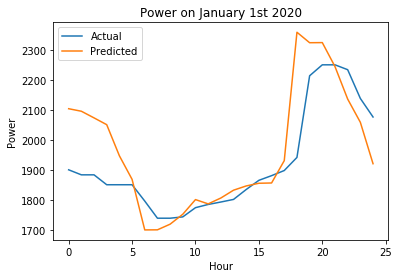

In [284]:
plt.plot(np.arange(25), y_pred[:25])
plt.plot(np.arange(25), january1st2020.Power[:25])
plt.xlabel('Hour')
plt.ylabel('Power')
plt.title('Power on January 1st 2020')
plt.legend(['Actual', 'Predicted'])

In [286]:
# plt.plot(np.arange(25), y_pred[25:50])
# plt.plot(np.arange(25), january1st2020.Power[25:50])
# plt.xlabel('Hour')
# plt.ylabel('Power')
# plt.title('Power on January 2nd 2020')
# plt.legend(['Actual', 'Predicted'])

#### Model Evaluation by Time

In [287]:
TestSet = pd.concat([X_test, y_test], axis=1)

In [288]:
first_eight_hours = TestSet[TestSet['Hour'] < 8]
y_pred = model.predict(first_eight_hours.drop('Power', axis=1))
mape = mean_absolute_percentage_error(y_pred, first_eight_hours['Power'])
rmse = np.sqrt(mean_squared_error(y_pred, first_eight_hours['Power']))

In [289]:
print(f'MAPE from 12am to 8am {round(mape, 2)}%')
print(f'RMSE from 12am to 8am {round(rmse, 2)} Watt')

MAPE from 12am to 8am 6.33%
RMSE from 12am to 8am 163.71 Watt


In [290]:
second_eight_hours = TestSet[(TestSet.Hour >= 8) & (TestSet.Hour < 16)]
y_pred = model.predict(second_eight_hours.drop('Power', axis=1))
mape = mean_absolute_percentage_error(y_pred, second_eight_hours['Power'])
rmse = np.sqrt(mean_squared_error(y_pred, second_eight_hours['Power']))

In [291]:
print(f'MAPE from 8am to 4pm {round(mape, 2)}%')
print(f'RMSE from 8am to 4pm {round(rmse, 2)} Watt')

MAPE from 8am to 4pm 6.64%
RMSE from 8am to 4pm 180.42 Watt


In [292]:
third_eight_hours = TestSet[(TestSet.Hour >= 16) & (TestSet.Hour < 24)]
y_pred = model.predict(third_eight_hours.drop('Power', axis=1))
mape = mean_absolute_percentage_error(y_pred, third_eight_hours['Power'])
rmse = np.sqrt(mean_squared_error(y_pred, third_eight_hours['Power']))

In [293]:
print(f'MAPE from 4pm to 12am {round(mape, 2)}%')
print(f'RMSE from 4pm to 12am {round(rmse, 2)} Watt')

MAPE from 4pm to 12am 6.35%
RMSE from 4pm to 12am 190.64 Watt


In [298]:
today = pd.DataFrame({
    'Year':2020,
    'Month' : 5,
    'Day' : 14,
    'Hour' : 9,
    'DayOfYear' : 133,
    'weekday' : 3,
    'is_weekend' : 0,
    'SpecialEvent' : 0,
    'Holiday' : 0
}, index=[0])

In [299]:
model.predict(today)
# X_test

ValueError: feature_names mismatch: ['Holiday', 'SpecialEvent', 'Year', 'Month', 'Day', 'Hour', 'DayOfYear', 'weekday', 'is_weekend'] ['Year', 'Month', 'Day', 'Hour', 'DayOfYear', 'weekday', 'is_weekend', 'SpecialEvent', 'Holiday']

In [296]:
fullData['Power'] = fullData['Power'].astype('float')

In [297]:
# sns.heatmap(fullData.corr(), annot=True)

In [ ]:
np.sqrt(mean_squared_error(y_pred, y_test))

In [ ]:
X_train.head()

In [ ]:
mape = mean_absolute_percentage_error(y_pred, y_test)

In [ ]:
mape

In [ ]:
# dump(model,'../short-term-models/model(' + str(round(mape,3)) + ').joblib')

In [ ]:
# X_train = train[['Year', 'Month', 'Day', 'Hour', 'DayOfYear']]
# Y_train = train[['Power']]

# X_test = data19[['Year', 'Month', 'Day', 'Hour', 'DayOfYear']]
# Y_test = data19[['Power']]

In [ ]:
X_test

In [ ]:
# model = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.001).fit(X_train, Y_train.values)

In [ ]:
model.score(X_train, Y_train)

In [ ]:
# model.score(X_test, Y_test)

In [67]:
from sklearn.metrics import mean_squared_error, r2_score

In [68]:
np.sqrt(mean_squared_error(model.predict(X_test), Y_test))

310.75158214044745

In [69]:
r2_score(Y_test, model.predict(X_test))

-0.5395787790684439

In [70]:
sns.heatmap(data= finalData.corr(), annot = True)

In [71]:
# plt.scatter(finalData.hour, )

In [72]:
X_test.head()

,Year,Month,Day,Hour,DayOfYear
0,2019,1,1,0,1
1,2019,1,1,1,1
2,2019,1,1,2,1
3,2019,1,1,3,1
4,2019,1,1,4,1


In [97]:
X_test.head()

,Year,Month,Day,Hour,DayOfYear,weekday,is_weekend
1970-01-01 00:00:00.000007273,2019,10,31,1,304,3,0
1970-01-01 00:00:00.000007274,2019,10,31,2,304,3,0
1970-01-01 00:00:00.000007275,2019,10,31,3,304,3,0
1970-01-01 00:00:00.000007276,2019,10,31,4,304,3,0
1970-01-01 00:00:00.000007277,2019,10,31,5,304,3,0


In [74]:
model.predict([X_test.loc[0]])

array([1604.09360052])

In [431]:
# data_2017

In [145]:
# plt.figure(figsize=(15,10))
# plt.plot(data17['DayOfYear'], data17['Power'])

In [78]:
predictions = model.predict(X_test)

In [146]:
# plt.plot(np.arange(24),Y_test[24:48])
# plt.plot(np.arange(24),predictions[24:48])

In [133]:
pd.DataFrame({
    'y_test' : y_test,
    'y_pred' : model.predict(X_test)
})

,y_test,y_pred
1970-01-01 00:00:00.000001004,2572.7,2383.623779
1970-01-01 00:00:00.000001005,2500.3,2367.546387
1970-01-01 00:00:00.000001006,2456.9,2278.456787
1970-01-01 00:00:00.000001007,2269.3,2220.514648
1970-01-01 00:00:00.000001008,2215.1,2110.558594
...,...,...
1970-01-01 00:00:00.000000187,2620.6,2301.289795
1970-01-01 00:00:00.000000188,2633.5,2301.289795
1970-01-01 00:00:00.000000189,2569.4,2285.212402
1970-01-01 00:00:00.000000190,2418.9,2196.123291
